## Clustering Functions for Homework 4

This notebook contains code to create the complete the clustering needed for homework 4.

Please read __ALL__ the comments in the code and the headings. This notebook is NOT intended to be run as a script from top to bottom, although there are some code cells that need to be run first.
- The general utility libraries need to be loaded first
- Then you need to execute the load data and engineer features code cells

In [1]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import math
import numpy as np
import pickle

import warnings
warnings.filterwarnings("ignore")

### PREP AND PREPROCESSING SECTION

###  Load the data and engineer features

In [2]:
# This is the code you can use to open your pickle file
# Read the data and features from the pickle
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "../clean_data.pickle", "rb" ) )

In [3]:
# Create a feature for the length of a person's credit history at the
# time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

#### If you want to use a smaller sample of the data due to time constraints, use the following code

In [4]:
# this code randomly samples 55% of the rows
# change the frac paramter if you want a different % to sample
# replace = False insures we won't select the same row twice
data=data.sample(frac=.55, replace=False, ).copy()

#### VERY IMPORTANT STEP
You need to define which features to use in the clustering.

In [5]:
# define the discrete features you want to use in modeling.
# if you want to use all the discrete features, just set discrete_features_touse = discrete_features
discrete_features_touse =['purpose', 'term', 'verification_status', 'emp_length', 'home_ownership']

# define the continuous features to use in modeling
# if you want to use all the continuous features, just set the continuous_features_touse = continuous_features
continuous_features_touse = ['loan_amnt', 'funded_amnt','installment','annual_inc','dti','revol_bal','delinq_2yrs','open_acc',
 'pub_rec','fico_range_high','fico_range_low','revol_util','cr_hist']

#### Run the code below if you want to use all the features

In [ ]:
discrete_features_touse=discrete_features
continuous_features_touse = continuous_features

#### Functions to scale data

In [6]:
from sklearn.preprocessing import MinMaxScaler

def minMaxScaleContinuous(continuousList):
    return pd.DataFrame(MinMaxScaler().fit_transform(data[continuousList])
                             ,columns=list(data[continuousList].columns)
                             ,index = data[continuousList].index)

def createDiscreteDummies(discreteList):
    return pd.get_dummies(data[discreteList], dummy_na = True, prefix_sep = "::", drop_first = False)

def createTransformedData(continuousList,discreteList):
    # use this line if you want to scale the continuous features using the MinMaxScaler in the function defined above
    continuous = minMaxScaleContinuous(continuousList)

    # create numeric dummy features for the discrete features to be used in modeling
    discrete = createDiscreteDummies(discreteList)

    #concatenate the continuous and discrete features into one dataframe
    return pd.concat([continuous, discrete], axis = 1)

#### Function to Determine Number of Clusters

In [7]:
from sklearn.cluster import KMeans

def determineClusters(transformed_data, range_min, range_max):
    Sum_of_squared_distances = []
    K = range(range_min, range_max)
    for k in K:
        km = KMeans(n_clusters=k, n_jobs=-1)
        km = km.fit(transformed_data)
        Sum_of_squared_distances.append(km.inertia_)
        
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

### Scale and Transform Data

- The continuous features are scaled and dummies are created for the discrete features
- The dataset is split into Training and Testing

In [8]:
transformed_data = pd.concat([createTransformedData(continuous_features_touse, discrete_features_touse),data[ret_cols]], axis = 1)
transformed_data.head()

,loan_amnt,funded_amnt,installment,annual_inc,dti,revol_bal,delinq_2yrs,open_acc,pub_rec,fico_range_high,...,home_ownership::MORTGAGE,home_ownership::NONE,home_ownership::OWN,home_ownership::RENT,home_ownership::nan,ret_PESS,ret_OPT,ret_INTa,ret_INTb,ret_INTc
751161,0.179487,0.179487,0.135483,0.005460,0.007297,0.002744,0.142857,0.114943,0.000000,0.026882,...,0,0,0,1,0,0.025626,0.092367,0.027436,0.046782,0.082686
417288,0.384615,0.384615,0.294496,0.008401,0.019770,0.007733,0.000000,0.068966,0.000000,0.053763,...,0,0,0,1,0,0.061750,0.060090,0.046981,0.062698,0.091252
247560,0.102564,0.102564,0.082315,0.004200,0.011572,0.004621,0.023810,0.091954,0.000000,0.188172,...,0,0,0,1,0,0.038933,0.116878,0.035631,0.055294,0.091718
226630,0.107051,0.107051,0.097891,0.002415,0.022513,0.002508,0.000000,0.126437,0.038462,0.134409,...,0,0,0,1,0,0.118255,0.118334,0.082447,0.100646,0.133729
697801,0.410256,0.410256,0.285732,0.012181,0.013584,0.011009,0.000000,0.057471,0.000000,0.725806,...,0,0,0,1,0,0.014322,0.046985,0.020165,0.038718,0.073118


In [9]:
from sklearn.model_selection import train_test_split

X = pd.concat([createTransformedData(continuous_features_touse, discrete_features_touse),data[ret_cols]], axis = 1)
#y = data[ret_cols]

# create a test and train split of the transformed data
X_train, X_test = train_test_split(X, random_state=0, test_size=.3)

clusterInput = X_train.iloc[:,:-len(ret_cols)]
predictInput = X_test.iloc[:,:-len(ret_cols)]


### Determine Number of Clusters

- Use the Elbow Method to determine proper number of clusters
- You can change the range_min and range_max parameters to control the range of clusters that are considered in the graph

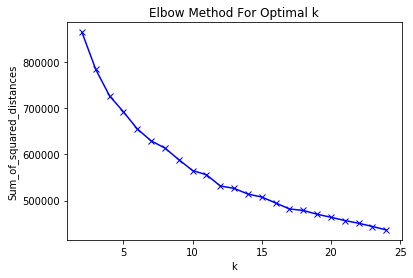

In [10]:
determineClusters(clusterInput, range_min=2, range_max=25)

### Fit Kmeans Clustering

- Fit the clustering on the training data
- The number of clusters parameter comes from the ideal number as determined by the Elbow method above
- The other parameters can be adjusted as well. You can find documentation at the link below

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [11]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=12, random_state=0, n_jobs=-1).fit(clusterInput)

print("Sum Squared Distances: ", kmeans.inertia_)

Sum Squared Distances:  550646.3058615786


### Add Cluster to the Training Data
- Create a dataframe of the standard deviations by cluster

In [12]:
X_train['cluster'] = kmeans.labels_

In [15]:
clusterStdDev=X_train.groupby('cluster')[ret_cols].std()

print(clusterStdDev)

         ret_PESS   ret_OPT  ret_INTa  ret_INTb  ret_INTc
cluster                                                  
0        0.080152  0.102231  0.050280  0.053814  0.060452
1        0.094290  0.117039  0.059141  0.063266  0.070952
2        0.102372  0.135052  0.073140  0.078320  0.087907
3        0.073677  0.129837  0.077352  0.083248  0.094198
4        0.091757  0.117098  0.057567  0.061609  0.069158
5        0.094111  0.117107  0.059043  0.063183  0.070894
6        0.071651  0.091757  0.044974  0.048188  0.054259
7        0.077818  0.137648  0.081734  0.088014  0.099671
8        0.086119  0.113684  0.060614  0.065096  0.073456
9        0.081461  0.105728  0.057047  0.061234  0.069064
10       0.093113  0.119651  0.058426  0.062539  0.070207
11       0.069778  0.088625  0.043780  0.046887  0.052773


### Get Clusters for Test Data

In [16]:
X_test['cluster'] = kmeans.predict(predictInput)

In [18]:
testClusterStdDev=X_test.groupby('cluster')[ret_cols].std()
print(testClusterStdDev)

         ret_PESS   ret_OPT  ret_INTa  ret_INTb  ret_INTc
cluster                                                  
0        0.081132  0.103409  0.050896  0.054474  0.061191
1        0.093169  0.115093  0.058432  0.062499  0.070082
2        0.101984  0.134538  0.072527  0.077641  0.087110
3        0.073517  0.130393  0.077199  0.083106  0.094078
4        0.091713  0.118035  0.057556  0.061623  0.069224
5        0.095296  0.118547  0.059794  0.063995  0.071819
6        0.068792  0.089699  0.043162  0.046223  0.052020
7        0.076911  0.137126  0.080794  0.087024  0.098590
8        0.086013  0.114085  0.059859  0.064289  0.072558
9        0.081706  0.104422  0.057664  0.061877  0.069751
10       0.094558  0.121767  0.059348  0.063548  0.071377
11       0.069656  0.089214  0.043706  0.046812  0.052696


In [24]:
df=pd.DataFrame(testClusterStdDev)
df.head(15)

,ret_PESS,ret_OPT,ret_INTa,ret_INTb,ret_INTc
cluster,,,,,
0,0.081132,0.103409,0.050896,0.054474,0.061191
1,0.093169,0.115093,0.058432,0.062499,0.070082
2,0.101984,0.134538,0.072527,0.077641,0.087110
3,0.073517,0.130393,0.077199,0.083106,0.094078
4,0.091713,0.118035,0.057556,0.061623,0.069224
5,0.095296,0.118547,0.059794,0.063995,0.071819
6,0.068792,0.089699,0.043162,0.046223,0.052020
7,0.076911,0.137126,0.080794,0.087024,0.098590
8,0.086013,0.114085,0.059859,0.064289,0.072558
